# 2D Oriented bounding boxes made simple
> Calculating 2D oriented bounding boxes. Oriented boxes are useful to avoid obstacles and make best utilitsation of the real navigationable space for autonomous vehicles to steer around.

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [LIDAR, sensor-fusion, jupyter]
- image: images/2Dbox/2d_oriented_bounding_box.png
- search_exclude: false

# Overview


# 2D oriented bounding box

Generating a bounding box around an object at first might sound trivial and fairly easy task to accomplish. But it is hardly the case when one starts to study the subject in detail, which is the case here.

## What is a bounding box?

The answer to this question lies within the name but a bit of context is needed to make complete sense of it. "Bounding box" i.e. a box that bounds something, some object, or some living thing. We, as humans have a sense of this bounding box by which we imagine a bubble/sphere around an obstacle while driving, like the cat which always troubles me while crossing the road on my bicycle, I am thinking of naming that cat "The Interruptor!", cause you know why. Anyway, so humans, imagine, sphere, avoid, obstacles! That is it, that is the motive behind why we are interested in such a box that bounds. Wait, you ask why did we shift from sphere to box? I think one possible reason is computers/autonoumous systems are capable of reacting much faster than us and the second and probably most important reason is to establish a definite NO-GO area which can later be enlarged based on a factor of safety. 

## Where do we use them?

That is a good question, isn't it? We use bounding boxes in autonoumous systems irrespective of the travel medium i.e. bounding boxes are used in self-driving cars, self-flying cars or copters etc. 

## What data are we working with?

In this post we work with some random data that emulates LIDAR data. But bounding boxes are used with both LIDAR pointclouds and digital images from a camera.

## Read enough and want to see what is the fuss about?

Do not worry, I have got it covered for the skimmers (cause am also one of you (keep it a secret though 🤫)). In the following picture on the left we can see that though the box bounds the data but does so poorly by marking lot of empty space also as belonging to the data (imagine how bad one would feel if fatness was exaggerated, not good right!) and on the right we can see that the new oriented box bounds the data perfectly and only to the extent necessary hence proving the autonomous vehicle/entity enough space to steer through.

![overview](../images/2Dbox/2d_oriented_bounding_box.png)

---
In this post the simple and yet informative 2D case is discussed as we move on to a 3D case in the next post. 

---
## Let us get started with the code and the math to generate a bounding box

### Handle some imports and set seed for the random generator

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA

# %matplotlib widget # uncomment this if you want to work with this notebook

np.random.seed(22)

### Generate 2D sample data and visualise it

(-6.0, 8.0)

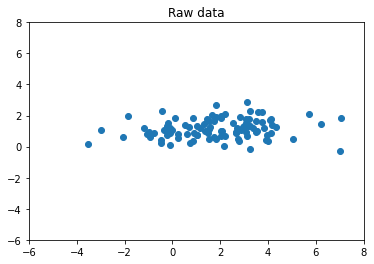

In [28]:
x = np.random.normal(2, 2, (1, 100))
y = np.random.normal(1, 0.6, (1, 100))
plt.title("Raw data")
plt.scatter(x, y)
plt.ylim(-6, 8)
plt.xlim(-6, 8)

### Rotate the data
Note: The rotated data whill be principal data that we will be working with. We rotate the data to avoid the trivial case where an oriented bounding box result will be same as a max-min based bounding box

In [ ]:
theta = 30 # rotation angle
# rotation matrix
rot = lambda theta: np.array([[np.cos(np.deg2rad(theta)), -np.sin(np.deg2rad(theta))],
                              [np.sin(np.deg2rad(theta)),  np.cos(np.deg2rad(theta))]])
# rotate the data using the rotation matrix
data = np.matmul(rot(theta), np.vstack([x, y]))

(-6.0, 8.0)

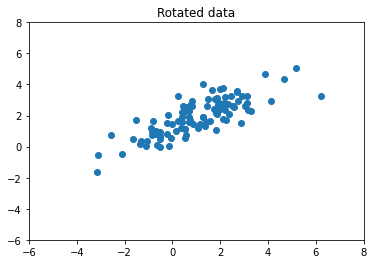

In [30]:
plt.title("Rotated data")
plt.scatter(data[0,:], data[1,:])
plt.ylim(-6, 8)
plt.xlim(-6, 8)

### Calculate means, covariance matrix, eigen values, and eigen vectors for the rotated data

In [52]:
means = np.mean(data, axis=1) # calculate the means
# calculate the covariance matrix
cov = np.cov(data)
# Calculate the eigen values and eigen vectors of the covariance matrix
eval, evec = LA.eig(cov)
eval, evec

(array([3.92880689, 0.37119218]),
 array([[ 0.83553491, -0.54943736],
        [ 0.54943736,  0.83553491]]))

Now, so far we haven't given a name to the method that we will be using to achieve our goal and this seems to be the right time. The method that we will be using is called PCA(Prinicipal Component Analysis), now the machine learning enthusiasts out there would be having a question, isn't PCA a dimension reductionality algorithm used to reduce dimensions in the data? Yes and yes, you are correct but it also gives us insight that the eigen-vectors i.e. the vectors which do not changes direction upon transformation gives us the information about the directions in which the data is oriented in. 

Hence, we will be making use of these eigen-vectors to align the data to our original cartesian basis vectors and use then use the max-min method to find oriented bounding boxes.

### Simple max and min based bounding box

Let us have a look at the drawback so that we are in a position to appreciate our end result

In [31]:
def draw2DRectangle(x1, y1, x2, y2):
    # diagonal line
    # plt.plot([x1, x2], [y1, y2], linestyle='dashed')
    # four sides of the rectangle
    plt.plot([x1, x2], [y1, y1], color='r') # -->
    plt.plot([x2, x2], [y1, y2], color='g') # | (up)
    plt.plot([x2, x1], [y2, y2], color='b') # <--
    plt.plot([x1, x1], [y2, y1], color='k') # | (down)

In [53]:
centerd_data = data - means[:, np.newaxis] # Translate the data to origin
# compute the minimums and maximums of each dimension
xmin, xmax, ymin, ymax = np.min(centerd_data[0,:]), np.max(centerd_data[0,:]), np.min(centerd_data[1,:]), np.max(centerd_data[1,:])

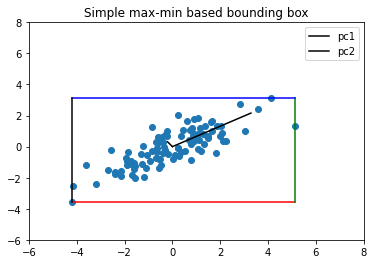

In [54]:
plt.title("Simple max-min based bounding box") # Plot the translated data along with the principal components i.e. the two orthogonal eigen vectors
plt.ylim(-6, 8)
plt.xlim(-6, 8)
plt.scatter(centerd_data[0,:], centerd_data[1,:])
draw2DRectangle(xmin, ymin, xmax, ymax)
# plot the eigen vactors scaled by their eigen values
plt.plot([0, eval[0] * evec[0, 0]],  [0, eval[0] * evec[1, 0]], label="pc1", color='k')
plt.plot([0, eval[1] * evec[0, 1]],  [0, eval[1] * evec[1, 1]], label="pc2", color='k')
plt.legend()

### Calculate angle of the principal eigen vector

In [55]:
def getEigenAngle(v):
    return np.rad2deg(np.arctan(v[1]/v[0]))

In [56]:
theta_pc1 = getEigenAngle(evec[:, 0]) # the eigen vectors are usually returned sorted based on their eigenvalues, 
# so we use the eigen vector in first column
theta_pc1

33.32842173633697

### Rotate the data to align to cartesian basis vectors

In [36]:
aligned_coords = np.matmul(rot(-theta_pc1), centerd_data) # notice the minus theta_pc1 angle

In [57]:
xmin, xmax, ymin, ymax = np.min(aligned_coords[0, :]), np.max(aligned_coords[0, :]), np.min(aligned_coords[1, :]), np.max(aligned_coords[1, :])
# compute the minimums and maximums of each dimension again

In [38]:
rectCoords = lambda x1, y1, x2, y2: np.array([[x1, x2, x2, x1],
                                              [y1, y1, y2, y2]])

(-6.0, 8.0)

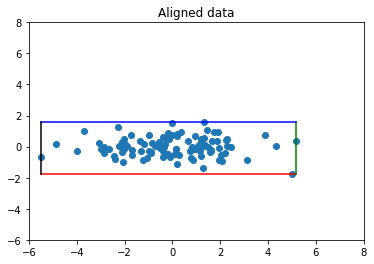

In [44]:
plt.title("Aligned data") # plot the rotated daa and its bounding box
plt.ylim(-6, 8)
plt.xlim(-6, 8)
plt.scatter(aligned_coords[0,:], aligned_coords[1,:])
draw2DRectangle(xmin, ymin, xmax, ymax)

### Rotate and translate the data back along with the oriented bounding box

In [40]:
rectangleCoordinates = rectCoords(xmin, ymin, xmax, ymax)

In [41]:
rotateBack = np.matmul(rot(theta_pc1), aligned_coords) # notice the plus theta_pc1 angle
rectangleCoordinates = np.matmul(rot(theta_pc1), rectangleCoordinates)

# translate back
rotateBack += means[:, np.newaxis]
rectangleCoordinates += means[:, np.newaxis]

(-6.0, 8.0)

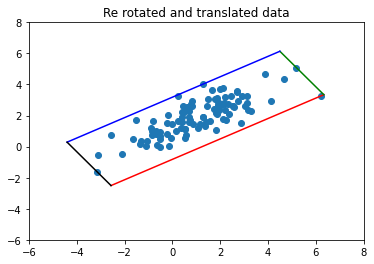

In [50]:
plt.title("Re rotated and translated data")
plt.ylim(-6, 8)
plt.xlim(-6, 8)
plt.scatter(rotateBack[0, :], rotateBack[1, :])
# four sides of the rectangle
plt.plot(rectangleCoordinates[0, 0:2], rectangleCoordinates[1, 0:2], color='r') # | (up)
plt.plot(rectangleCoordinates[0, 1:3], rectangleCoordinates[1, 1:3], color='g') # -->
plt.plot(rectangleCoordinates[0, 2:], rectangleCoordinates[1, 2:], color='b')    # | (down)
plt.plot([rectangleCoordinates[0, 3], rectangleCoordinates[0, 0]], [rectangleCoordinates[1, 3], rectangleCoordinates[1, 0]], color='k')    # <--

And so, there we have it! We made use of eigen vectors to rotate and align the data and then use the max-min method to determine a bounding box and finally undone the rotation and translation to get our oriennted bounding box.

## 2D Rotation example

This is just an additional illustration to show the rotation in action using the rotation matrix

In [58]:
x = np.matmul(rot(90), np.array([[2], [0]])) # rotate the vecctor (2, 0) by 90 degrees anti-clockwise


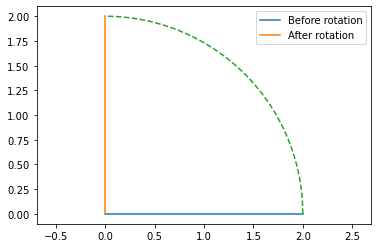

In [18]:
plt.plot([0, 2], [0, 0], label="Before rotation")
plt.plot([0, x[0,0]], [0, x[1,0]], label="After rotation")
plt.plot(2 * np.cos(np.linspace(0, np.pi/2, 50)), 2 * np.sin(np.linspace(0, np.pi/2, 50)), linestyle="dashed")
plt.axis("equal")
plt.legend()